In [1]:
from pennylane import numpy as np
import pennylane as qml 
from Z2 import * 

In [13]:
N = 3
p = 2

# variational circuit for state 
def circuit(param, # p X (N+N) thetas and phis  
            w #wires list 
            ):
    (p, _)  = param.shape
    N = len(w)
    # prepare |+> state with Hadamard gate 
    for i in range(N):
        qml.Hadamard(wires = w[i])
    # parametrized circuit with depth p 
    for step in range(p):
        for i in range(N):
            qml.RX(param[step, i], wires = w[i]) # exp(-i X phi/2)
        for i in range(N-1):
            qml.CNOT(wires = w[i: i+2])
            qml.RZ(param[step, i], wires = w[i+1])
            qml.CNOT(wires = w[i: i+2])
        qml.CNOT(wires = [w[N-1], w[0]])
        qml.RZ(param[step, N-1], wires = w[N-1])
        qml.CNOT(wires = [w[N-1], w[0]])

    # return qml.probs(wires = w)

H = generate_Hamiltonian(N)
    
energy_list, param = find_groundstate(N, p, circuit, H)


  (-1.0) [Z0 Z1]
+ (-1.0) [Z1 Z2]
+ (-1.0) [Z2 Z0]


['|000>', '|001>', '|010>', '|011>', '|100>', '|101>', '|110>', '|111>']


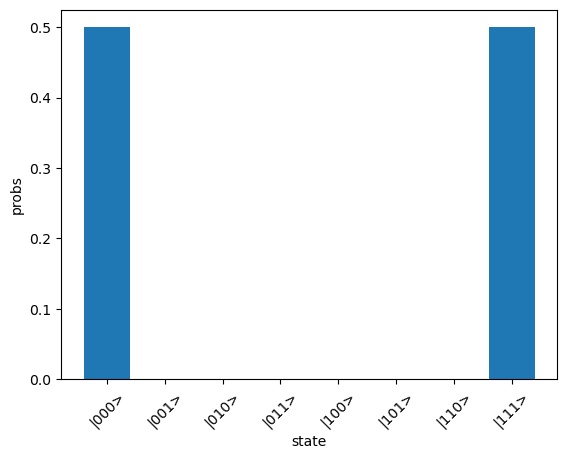

In [15]:
def circuit2(param, w): 
    circuit(param, w)
    return qml.probs(w)
dev = qml.device("default.qubit", wires = N)
qnode = qml.QNode(circuit2, dev)
probs = qnode(param, range(N)).numpy()
plt.bar(range(2**N), probs) 
x_tick_num = np.arange(2**N, step = 2**(0))
x_ticks = ["|"+str(format(i, '0'+str(N)+'b'))+">" for i in x_tick_num]
print(x_ticks)
plt.xticks(x_tick_num, labels = x_ticks, rotation = 45)
plt.xlabel('state')
plt.ylabel('probs')
# plt.axis([0, 31, 0, 1])
plt.show()